https://www.kaggle.com/tunguz/instant-eda/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import time
from sklearn import preprocessing
import warnings
import datetime
warnings.filterwarnings("ignore")
import gc
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold

from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
#Loading Train and Test Data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("{} observations and {} features in train set.".format(train.shape[0],train.shape[1]))
print("{} observations and {} features in test set.".format(test.shape[0],test.shape[1]))

262144 observations and 258 features in train set.
131073 observations and 257 features in test set.


In [3]:
train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [4]:
test.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,1c13f2701648e0b0d46d8a2a5a131a53,-5.490030,0.593976,1.532732,-0.361234,-0.155282,-1.340582,1.626819,4.280084,-0.340155,-0.653070,2.817394,1.211543,-0.819354,-0.019935,0.634466,-1.604789,0.756771,0.451960,0.309252,-4.628353,-0.270163,-0.183827,0.099529,0.719685,-1.077965,-1.704726,0.263344,1.183083,-1.967262,-0.364729,-1.553005,0.667643,-1.647120,-0.118086,1.095897,-3.725086,0.571565,5.407131,1.599479,...,-0.007170,-0.723353,-0.317083,3.892687,0.732599,-0.829353,-1.281645,5.256029,0.484761,0.315440,-1.256456,-0.065537,0.243787,-0.085292,0.293226,-0.727176,-0.026991,-0.452266,1.733475,-0.511201,-0.913642,-2.237558,-1.607618,-0.497308,0.004124,-1.854472,1.499102,-0.701304,-0.573827,0.121455,0.386831,0.817764,-1.215121,0.238812,-0.507346,1.360599,-1.743894,1.412043,-0.562730,-0.237948
1,ba88c155ba898fc8b5099893036ef205,0.571698,0.495494,1.133975,-0.315875,-2.142458,-0.478650,-1.458941,0.977352,0.159189,0.425304,1.366214,-1.097810,-0.128929,-0.563375,-0.389307,-0.167991,0.314843,0.530220,-0.512497,0.526404,1.612939,-0.800211,0.692056,2.541566,0.290910,-0.726153,1.307040,0.964062,0.235339,3.553998,-0.769491,-1.706831,0.227793,-1.027914,1.359388,-1.296281,0.216550,0.166792,-1.361746,...,8.867017,0.145251,-2.429107,-1.994984,0.692641,-0.922336,-0.442788,-0.357402,0.606270,-0.144259,-0.019312,0.132073,-1.038829,-0.361597,-0.019181,0.656320,-0.029080,-0.263428,-1.674349,0.237658,-0.539413,3.683862,0.341788,0.321800,1.919056,-0.680074,-0.851474,-0.802017,1.984299,0.606214,-1.120400,-0.953432,0.266619,-2.088512,0.252637,-1.034676,-0.804765,0.639112,1.172667,-1.666513
2,7cbab5cea99169139e7e6d8ff74ebb77,0.478202,-1.429985,0.41

In [5]:
train.target.describe()

count    262144.000000
mean          0.500225
std           0.500001
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64

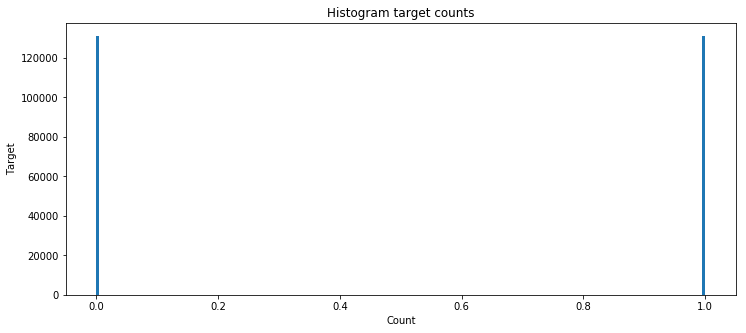

In [6]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

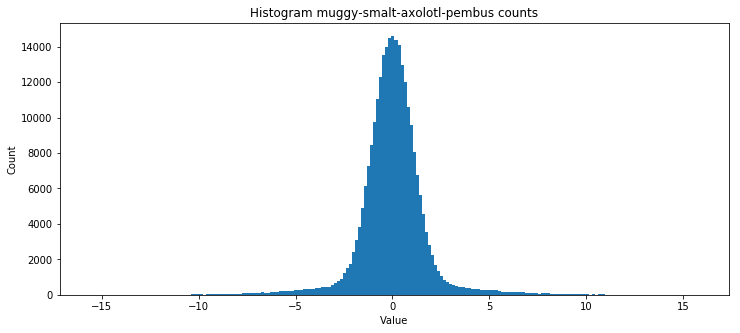

In [7]:
plt.figure(figsize=(12, 5))
plt.hist(train['muggy-smalt-axolotl-pembus'].values, bins=200)
plt.title('Histogram muggy-smalt-axolotl-pembus counts')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

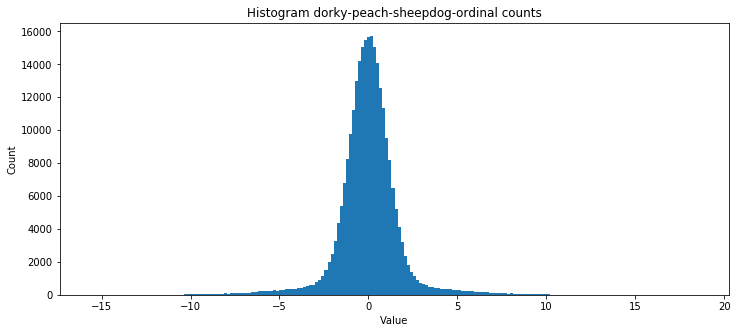

In [12]:
plt.figure(figsize=(12, 5))
plt.hist(train['dorky-peach-sheepdog-ordinal'].values, bins=200)
plt.title('Histogram dorky-peach-sheepdog-ordinal counts')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

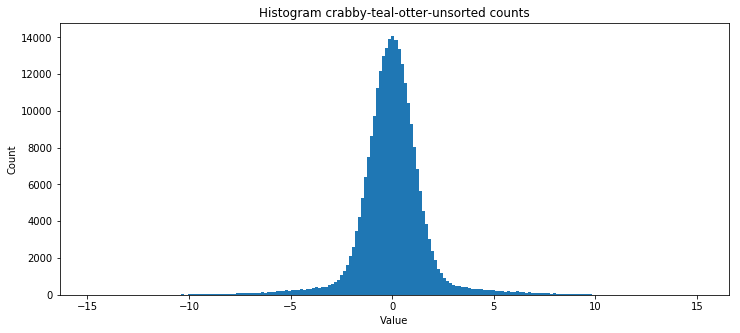

In [13]:
plt.figure(figsize=(12, 5))
plt.hist(train['crabby-teal-otter-unsorted'].values, bins=200)
plt.title('Histogram crabby-teal-otter-unsorted counts')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

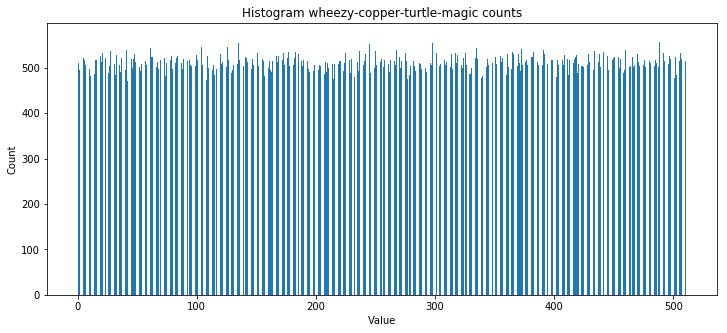

In [14]:
plt.figure(figsize=(12, 5))
plt.hist(train['wheezy-copper-turtle-magic'].values, bins=1000)
plt.title('Histogram wheezy-copper-turtle-magic counts')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [15]:
train.describe()

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000
mean,0.005924,0.000936,-0.012530,-0.005688,0.001607,0.007878,-0.003500,-0.005927,0.002664,0.020485,-0.001629,0.008115,-0.001445,0.006434,0.013150,-0.016462,0.014498,0.000990,-0.004702,-0.010490,0.006592,-0.007705,0.010857,-0.011858,-0.005172,-0.012855,-0.003606,0.001209,0.007980,-0.005911,-0.000397,-0.000490,-0.013010,-0.000040,0.003882,-0.008507,-0.009352,0.007037,0.004091,-0.011576,...,-0.002381,-0.010963,0.005069,0.001779,0.011217,-0.000718,-0.008141,0.003521,0.011593,-0.011187,0.001626,0.000656,0

In [17]:
test.describe()

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
count,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,...,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000
mean,0.000717,-0.001042,-0.014509,-0.007666,0.003343,0.001975,-0.003154,-0.003252,-0.000867,0.021517,0.008928,-0.001051,-0.006368,-0.002891,0.010515,-0.023823,0.000880,0.003780,-0.009165,-0.000505,0.011933,-0.003440,0.005804,0.003148,-0.016712,-0.009732,-0.002171,0.001297,0.009926,-0.003764,-0.003134,-0.010153,-0.014269,-0.000145,0.003224,-0.012756,-0.003288,0.000392,0.006548,-0.012575,...,0.006470,-0.010495,-0.008946,0.008752,0.002811,0.020735,-0.002210,-0.009315,0.007151,0.007063,-0

Even thought the features seem to be on an approximately same scale, there are some noticable differences. We'll try to deal with them, as per the following kernel - https://www.kaggle.com/ilu000/instagrat-lgbm-baseline

In [18]:
def normal(train, test):
    print('Scaling with StandardScaler\n')
    len_train = len(train)

    traintest = pd.concat([train,test], axis=0, ignore_index=True).reset_index(drop=True)
    
    scaler = StandardScaler()
    cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
    traintest[cols] = scaler.fit_transform(traintest[cols])
    traintest['wheezy-copper-turtle-magic'] = traintest['wheezy-copper-turtle-magic'].astype('category')
    train = traintest[:len_train].reset_index(drop=True)
    test = traintest[len_train:].reset_index(drop=True)

    return train, test

In [19]:
%%time
train, test = normal(train, test)

Scaling with StandardScaler

CPU times: user 19.8 s, sys: 8.71 s, total: 28.5 s
Wall time: 28.5 s


Now we are going to build a simple model. We'll start with a simple Logistic Regression, which will give us a baseline to work with. Then we'll build upon that.

In [20]:
%%time
featues_to_use = [c for c in train.columns if c not in ['id', 'target']]
target = train['target']
#train = train[featues_to_use]
#test = test[featues_to_use]
#classifier = LogisticRegression(C=1, solver='sag')
#cv_score = np.mean(cross_val_score(classifier, train, target, cv=3, scoring='roc_auc'))
#print(cv_score)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 419 µs


In [21]:
%%time
folds = KFold(n_splits=10, shuffle=True, random_state=137)
oof = np.zeros(train.shape[0])
pred = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_+1))
    x_train, y_train = train.iloc[trn_idx][featues_to_use], target.iloc[trn_idx]
    x_val, y_val = train.iloc[val_idx][featues_to_use], target.iloc[val_idx]
    classifier = LogisticRegression(C=1, solver='sag')
    classifier.fit(x_train, y_train)
    val_pred = classifier.predict_proba(x_val)[:,1]
    oof[val_idx] = val_pred
    pred += classifier.predict_proba(test[featues_to_use])[:,1]/10
    print(roc_auc_score(y_val, val_pred))
    
print(roc_auc_score(target.values, oof))

Fold 1
0.5318352647664581
Fold 2
0.5269563606131771
Fold 3
0.5300253653862859
Fold 4
0.5349074631356069
Fold 5
0.5262078132952055
Fold 6
0.5318361492176282
Fold 7
0.5305314030369773
Fold 8
0.529811408943298
Fold 9
0.5285584392822743
Fold 10
0.5284523798526197
0.5298819518950229
CPU times: user 8min 23s, sys: 47.7 s, total: 9min 11s
Wall time: 9min 3s


The following part is based on Chris Deotte's Logistic Regression kernel: https://www.kaggle.com/cdeotte/logistic-regression-0-800

In [22]:
%%time

NFOLDS = 25
NVALUES = 512

cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=137)
oof_lr = np.zeros(train.shape[0])
pred_lr = np.zeros(test.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_+1))
    x_train = train.iloc[trn_idx]
    x_val, y_val = train.iloc[val_idx], target.iloc[val_idx]
    
    
    for i in tqdm(range(NVALUES)):
        # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
        x_train_2 = x_train[x_train['wheezy-copper-turtle-magic']==i]
        x_val_2 = x_val[x_val['wheezy-copper-turtle-magic']==i]
        test_2 = test[test['wheezy-copper-turtle-magic']==i]
        idx1 = x_train_2.index; idx2 = x_val_2.index; idx3 = test_2.index
        x_train_2.reset_index(drop=True,inplace=True)
        x_val_2.reset_index(drop=True,inplace=True)
        test_2.reset_index(drop=True,inplace=True)
        clf = LogisticRegression(solver='liblinear',penalty='l1',C=0.05)
        y_train =x_train_2['target']
        clf.fit(x_train_2[cols],y_train)
        
        oof_lr[idx2] = clf.predict_proba(x_val_2[cols])[:,1]
        pred_lr[idx3] += clf.predict_proba(test_2[cols])[:,1] / NFOLDS

    oof_lr_val = oof_lr[val_idx]

    
    print(roc_auc_score(y_val, oof_lr_val))
    
print(roc_auc_score(target, oof_lr))

Fold 1


100%|██████████| 512/512 [00:19<00:00, 26.77it/s]


0.804685053468928
Fold 2


100%|██████████| 512/512 [00:19<00:00, 26.26it/s]


0.8066179278123462
Fold 3


100%|██████████| 512/512 [00:18<00:00, 27.36it/s]


0.8018887633597759
Fold 4


100%|██████████| 512/512 [00:18<00:00, 27.54it/s]


0.7944907170893617
Fold 5


100%|██████████| 512/512 [00:18<00:00, 27.72it/s]


0.7987005008968044
Fold 6


100%|██████████| 512/512 [00:18<00:00, 27.61it/s]


0.7989362953451492
Fold 7


100%|██████████| 512/512 [00:18<00:00, 27.33it/s]


0.80166451762875
Fold 8


100%|██████████| 512/512 [00:18<00:00, 28.17it/s]


0.8023305647758953
Fold 9


100%|██████████| 512/512 [00:18<00:00, 27.45it/s]


0.8035844460947987
Fold 10


100%|██████████| 512/512 [00:18<00:00, 27.50it/s]


0.8009366640419846
Fold 11


100%|██████████| 512/512 [00:18<00:00, 27.18it/s]


0.7932007095917665
Fold 12


100%|██████████| 512/512 [00:18<00:00, 27.72it/s]


0.8016309406165256
Fold 13


100%|██████████| 512/512 [00:18<00:00, 27.12it/s]


0.7959718498769237
Fold 14


100%|██████████| 512/512 [00:18<00:00, 27.13it/s]


0.7993335346640567
Fold 15


100%|██████████| 512/512 [00:18<00:00, 27.72it/s]


0.7885698120347259
Fold 16


100%|██████████| 512/512 [00:18<00:00, 27.62it/s]


0.7967691512818461
Fold 17


100%|██████████| 512/512 [00:19<00:00, 26.39it/s]


0.8004261055603665
Fold 18


100%|██████████| 512/512 [00:19<00:00, 26.90it/s]


0.8020911591555753
Fold 19


100%|██████████| 512/512 [00:18<00:00, 27.42it/s]


0.8076192884535616
Fold 20


100%|██████████| 512/512 [00:18<00:00, 27.34it/s]


0.7934606932083628
Fold 21


100%|██████████| 512/512 [00:18<00:00, 28.35it/s]


0.7934091719485661
Fold 22


100%|██████████| 512/512 [00:18<00:00, 28.38it/s]


0.7951978620132586
Fold 23


100%|██████████| 512/512 [00:18<00:00, 28.02it/s]


0.8025854503380174
Fold 24


100%|██████████| 512/512 [00:18<00:00, 28.36it/s]


0.8000618910048829
Fold 25


100%|██████████| 512/512 [00:17<00:00, 28.85it/s]


0.7921002918082651
0.7990382258112112
CPU times: user 10min 46s, sys: 20min 8s, total: 30min 55s
Wall time: 8min 2s


In [23]:
print(roc_auc_score(target, oof_lr))

0.7990382258112112


The following is Chris Deotte's SVM solution:

https://www.kaggle.com/cdeotte/support-vector-machine-0-925

In [24]:
# INITIALIZE VARIABLES
oof_svm = np.zeros(len(train))
preds_svm = np.zeros(len(test))
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

# BUILD 512 SEPARATE NON-LINEAR MODELS
for i in range(512):
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD (Using splits=25 scores 0.002 better but is slower)
    skf = StratifiedKFold(n_splits=11, random_state=42)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL WITH SUPPORT VECTOR MACHINE
        clf = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_svm[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds_svm[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
    #if i%10==0: print(i)
        
# PRINT VALIDATION CV AUC
auc = roc_auc_score(train['target'],oof_svm)
print('CV score =',round(auc,5))

CV score = 0.92595


In [25]:
roc_auc_score(train['target'],0.6*oof_svm+0.4*oof_lr)

0.940060998624676

The following is based on Rob Mulla's script https://www.kaggle.com/robikscube/eda-and-baseline-lgb-for-instant-gratification

In [26]:
'''%%time

param = {
    'bagging_freq': 3,
    'bagging_fraction': 0.8,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.9,
    'learning_rate': 0.05,
    'max_depth': 10,  
    'metric':'auc',
    'min_data_in_leaf': 82,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 10,
    'objective': 'binary', 
    'verbosity': 1
}

folds = KFold(n_splits=10, shuffle=True, random_state=137)
oof_lgb = np.zeros(train.shape[0])
pred_lgb = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_+1))
    x_train, y_train = train.iloc[trn_idx][featues_to_use], target.iloc[trn_idx]
    x_val, y_val = train.iloc[val_idx][featues_to_use], target.iloc[val_idx]
    trn_data = lgb.Dataset(x_train, label=y_train)
    val_data = lgb.Dataset(x_val, label=y_val)
    classifier = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 300)

    val_pred = classifier.predict(x_val, num_iteration=classifier.best_iteration)
    oof_lgb[val_idx] = val_pred
    pred_lgb += classifier.predict(test[featues_to_use], num_iteration=classifier.best_iteration)/10
    print(roc_auc_score(y_val, val_pred))'''

'%%time\n\nparam = {\n    \'bagging_freq\': 3,\n    \'bagging_fraction\': 0.8,\n    \'boost_from_average\':\'false\',\n    \'boost\': \'gbdt\',\n    \'feature_fraction\': 0.9,\n    \'learning_rate\': 0.05,\n    \'max_depth\': 10,  \n    \'metric\':\'auc\',\n    \'min_data_in_leaf\': 82,\n    \'min_sum_hessian_in_leaf\': 10.0,\n    \'num_leaves\': 10,\n    \'objective\': \'binary\', \n    \'verbosity\': 1\n}\n\nfolds = KFold(n_splits=10, shuffle=True, random_state=137)\noof_lgb = np.zeros(train.shape[0])\npred_lgb = 0\n\nfor fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):\n    print("Fold {}".format(fold_+1))\n    x_train, y_train = train.iloc[trn_idx][featues_to_use], target.iloc[trn_idx]\n    x_val, y_val = train.iloc[val_idx][featues_to_use], target.iloc[val_idx]\n    trn_data = lgb.Dataset(x_train, label=y_train)\n    val_data = lgb.Dataset(x_val, label=y_val)\n    classifier = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], v

In [27]:
%%time
submission = pd.read_csv('../input/sample_submission.csv')


'''submission['target'] = pred_lr
submission.to_csv('submission_0.csv', index=False)
submission['target'] = 0.9*pred_lr + 0.1*pred_lgb
submission.to_csv('submission.csv', index=False)
submission['target'] = 0.8*pred_lr + 0.2*pred_lgb
submission.to_csv('submission_2.csv', index=False)'''


submission['target'] = 0.6*preds_svm + 0.4*pred_lr
submission.to_csv('submission_3.csv', index=False)

CPU times: user 652 ms, sys: 0 ns, total: 652 ms
Wall time: 663 ms
